<a href="https://colab.research.google.com/github/CharlesArnal/Deep_Atlas/blob/main/Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments


In [ ]:
#%load_ext tensorboard
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import datetime
from copy import deepcopy
import math
import pickle
import scipy.io as sio
import sklearn.datasets
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.svm import LinearSVC

from scipy.stats import iqr

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

# Mount Google Drive
from google.colab import drive, files
import sys
drive.mount('/content/drive', force_remount = True)

sys.path.append('/content/drive/MyDrive/Productions mathématiques/GeoDiffEncoder')
from PCAE import PCAE, Chart, Gating_network

"""
with open('example.txt', 'w') as f:
  f.write('some content')
files.download('example.txt')
"""

Mounted at /content/drive


"\nwith open('example.txt', 'w') as f:\n  f.write('some content')\nfiles.download('example.txt')\n"

## Fit PCAE

In [ ]:
drive.mount('/content/drive', force_remount = True)
# Download data
dataset = 'truncated_grid_sphere'

npzfile = np.load('/content/drive/MyDrive/Productions mathématiques/GeoDiffEncoder/Datasets/'+dataset+'_data.npz')
training_data = npzfile["training_data"]
test_data = npzfile["test_data"]


# Turn the data into tensors
test_data =  tf.convert_to_tensor(test_data, dtype = tf.float32)
training_data =  tf.convert_to_tensor(training_data,dtype = tf.float32)

# Renormalize data
std_dataset = tf.cast(tf.math.reduce_euclidean_norm(tf.math.reduce_std(training_data, axis = 0)),tf.float32)
tf.print(std_dataset)

training_data /= std_dataset
test_data /= std_dataset

# Define PCAE
charts = []
rest_of_the_network = tf.keras.Sequential()
#rest_of_the_network.add( tf.keras.layers.Dense(7, activation= "relu"))
#rest_of_the_network.add( tf.keras.layers.Dense(25, activation= "tanh"))
#rest_of_the_network = None
for i in range(1):
  charts.append(Chart([10,10,2],[tf.nn.tanh, tf.nn.tanh, None],[10,10,3],[tf.nn.tanh, tf.nn.tanh, None]))
gating_network = Gating_network(output_layer = tf.keras.layers.Dense(len(charts), activation= None),rest_of_the_network = rest_of_the_network)

alpha_load = 0.0
alpha_importance = 0.0
alpha_classification= 0
alpha_inverse_reconstruction=0
charts_weights_inside_norm = False
load_softmax_like = False
load_softmax_exponent = 4
softmax_exponent = 1.0
clustering_space = "input_space"
clustering_alg = "k_means"
split_chart_tolerance = 0.0001

my_PCAE = PCAE(charts,gating_network, charts_weights_inside_norm = charts_weights_inside_norm, \
               load_softmax_like = load_softmax_like, load_softmax_exponent = load_softmax_exponent, \
               softmax_exponent = softmax_exponent , alpha_load = alpha_load, alpha_importance = alpha_importance,\
               alpha_classification= alpha_classification, alpha_inverse_reconstruction=alpha_inverse_reconstruction)
my_PCAE.charts_weights_inside_norm = False

batch_size = 500
optimizer = tf.keras.optimizers.Adam(
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-04*10,
)
run_eagerly = False

my_PCAE.compile(optimizer=optimizer, run_eagerly=run_eagerly)


tf.debugging.enable_check_numerics()

N = 1

x_reconstructed_test_saved =[]
x_reconstructed_training_saved=[]
indices_charts_test_saved=[]
indices_charts_training_saved=[]
z_training_saved=[]
z_test_saved=[]
class0_split_saved= np.zeros((N,), dtype=np.object)
class1_split_saved= np.zeros((N,), dtype=np.object)


#my_PCAE.fit(training_data,epochs=50,batch_size=batch_size)
for i in range(N):
  for j, epochs in enumerate([50,400,400]):
    optimizer.epsilon = 1e-04 *(10**(1-j))*(2.5**(-i))
    my_PCAE.compile(optimizer=optimizer, run_eagerly=run_eagerly)
    my_PCAE.fit(training_data,epochs=epochs,batch_size=batch_size)
    tf.print(str(i)+" : "+str(j))
  [z_test,indices_charts_test,x_reconstructed_test]=my_PCAE(test_data,training = False)
  [z_training,indices_charts_training,x_reconstructed_training]=my_PCAE(training_data,training = False)
   # average error
  tf.print(tf.reduce_mean(tf.reduce_sum(tf.math.square(test_data-x_reconstructed_test),axis=1),0))
  class_split = my_PCAE.create_new_chart(tf.random.shuffle(training_data)[0:1000],split_chart_tolerance,clustering_space = clustering_space, clustering_alg = clustering_alg )
  # Saves the results
  x_reconstructed_test_saved.append(x_reconstructed_test.numpy())
  x_reconstructed_training_saved.append(x_reconstructed_training.numpy())
  indices_charts_test_saved.append(indices_charts_test.numpy())
  indices_charts_training_saved.append(indices_charts_test.numpy())
  z_training_saved.append(z_training.numpy())
  z_test_saved.append(z_test.numpy())
  class0_split_saved[i] = class_split["class0"]
  class1_split_saved[i] = class_split["class1"]
  
  
results = {"test_data": test_data.numpy(),\
        "training_data": training_data.numpy(),\
        "test_reconstructed": np.array(x_reconstructed_test_saved), \
        "training_reconstructed": np.array(x_reconstructed_training_saved), \
        "indices_training": np.array(indices_charts_training_saved), \
        "indices_test": np.array(indices_charts_test_saved), \
        "z_training":np.array(z_training_saved), \
        "z_test":np.array(z_test_saved),\
        "class0": class0_split_saved,\
        "class1": class1_split_saved}
# Downloads the results as .mat files on the local machine, as well as numpy archives on Google Drive
sio.savemat(dataset+"_results_fit_PCAE.mat",results)
files.download(dataset+"_results_fit_PCAE.mat")
np.savez('/content/drive/MyDrive/Productions mathématiques/GeoDiffEncoder/Results/Fit_PCAE/'+dataset,**results)


  # A faire: voir charts pour training et test
# afficher et les points originaux, et leur reconstruction (avec peut-être une petite flèche?)
# essayer l'affichage surface?
# comparer avec un encoder simple
# tester différentes configurations
# tester sur les autres jeux de données

Mounted at /content/drive
0.990053952
INFO:tensorflow:Enabled check-numerics callback in thread MainThread


Exception ignored in: <function NpzFile.__del__ at 0x7f0085411170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 223, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 218, in close
    self.fid.close()
OSError: [Errno 107] Transport endpoint is not connected


Epoch 1/50
10/10 [==============================] - 1s 9ms/step - main reconstruction loss: 0.7711 - number of charts: 1.0000
Epoch 2/50
10/10 [==============================] - 0s 10ms/step - main reconstruction loss: 0.6169 - number of charts: 1.0000
Epoch 3/50
10/10 [==============================] - 0s 10ms/step - main reconstruction loss: 0.4889 - number of charts: 1.0000
Epoch 4/50
10/10 [==============================] - 0s 9ms/step - main reconstruction loss: 0.4129 - number of charts: 1.0000
Epoch 5/50
10/10 [==============================] - 0s 10ms/step - main reconstruction loss: 0.3654 - number of charts: 1.0000
Epoch 6/50
10/10 [==============================] - 0s 9ms/step - main reconstruction loss: 0.3516 - number of charts: 1.0000
Epoch 7/50
10/10 [==============================] - 0s 10ms/step - main reconstruction loss: 0.3480 - number of charts: 1.0000
Epoch 8/50
10/10 [==============================] - 0s 10ms/step - main reconstruction loss: 0.3346 - number of ch

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Show extended charts


In [ ]:
drive.mount('/content/drive', force_remount = True)
num_charts = len(my_PCAE.list_of_charts)

extended_charts = np.zeros((num_charts,), dtype=np.object)

for i in range(num_charts):
  extended_chart = np.zeros((2,), dtype=np.object)
  encoded_points = []
  images = []
  for a in np.linspace(-2,2, num=60):
    for b in np.linspace(-2,2, num=60):
      encoded_points.append(np.array([a,b]))
      images.append(my_PCAE.list_of_charts[i].decode(tf.convert_to_tensor([[a,b]])).numpy()[0,:])
  extended_chart[0] = np.array(encoded_points)
  extended_chart[1] = np.array(images)
  extended_charts[i] = extended_chart
  print("Chart "+str(i)+" done")

extended_charts_saved = {"extended_charts": extended_charts}

sio.savemat(dataset+"_extended_charts.mat",extended_charts_saved)
files.download(dataset+"_extended_charts.mat")
np.savez('/content/drive/MyDrive/Productions mathématiques/GeoDiffEncoder/Results/Various_visualisations/'+dataset+"_extended_charts",**extended_charts_saved)




## Classical methods



Automatically created module for IPython interactive environment


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


ISO: 7.2 sec
MDS: 44 sec


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Spectral Embedding: 1.5 sec
t-SNE: 26 sec


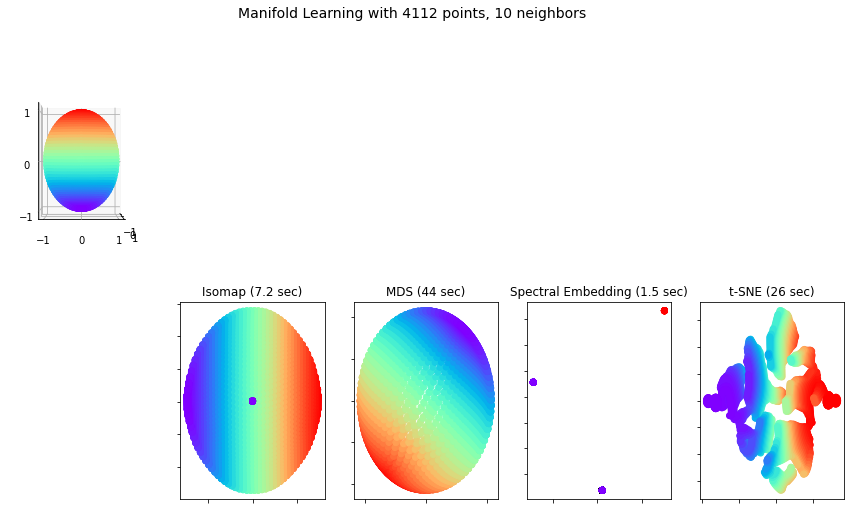

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Author: Jaques Grobler <jaques.grobler@inria.fr> (+ Charles Arnal)
# License: BSD 3 clause

print(__doc__)

from time import time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold
from sklearn.utils import check_random_state

# Next line to silence pyflakes.
Axes3D

# Download data
#drive.mount('/content/drive', force_remount = True)

dataset = 'grid_sphere'

npzfile = np.load('/content/drive/MyDrive/Productions mathématiques/GeoDiffEncoder/Datasets/'+dataset+'_data.npz')
data = npzfile["training_data"]
# not always relevant
colors = data[:,2]/np.amax(np.abs(data[:,2]))


# Variables for manifold learning.
n_neighbors = 10
# TODO check if useful
n_samples = data.shape[0]


# Plot our dataset.
fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (n_samples, n_neighbors), fontsize=14)

ax = fig.add_subplot(251, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], c=colors, cmap=plt.cm.rainbow)
ax.view_init(0, -0)


results = {"data": data}

"""
# Perform Locally Linear Embedding Manifold learning
methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    images = manifold.LocallyLinearEmbedding(n_neighbors, 2, method=method).fit_transform(data).T
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(images[0], images[1], c=colors, cmap=plt.cm.rainbow)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    results[method+"_LLE"] = images.T
"""

# Perform Isomap Manifold learning.
t0 = time()
images = manifold.Isomap(n_neighbors, n_components=2)\
    .fit_transform(data).T
   
t1 = time()
print("%s: %.2g sec" % ('ISO', t1 - t0))

ax = fig.add_subplot(257)
plt.scatter(images[0], images[1], c=colors, cmap=plt.cm.rainbow)
plt.title("%s (%.2g sec)" % ('Isomap', t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

results["Isomap"] = images.T


# Perform Multi-dimensional scaling.
t0 = time()
mds = manifold.MDS(2, max_iter=100, n_init=1)
images = mds.fit_transform(data).T
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(258)
plt.scatter(images[0], images[1], c=colors, cmap=plt.cm.rainbow)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

results["MDS"] = images.T

# Perform Spectral Embedding.
t0 = time()
se = manifold.SpectralEmbedding(n_components=2,
                                n_neighbors=n_neighbors)
images = se.fit_transform(data).T
t1 = time()
print("Spectral Embedding: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(259)
plt.scatter(images[0], images[1], c=colors, cmap=plt.cm.rainbow)
plt.title("Spectral Embedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

results["Spectral_Embedding"] = images.T

# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
images = tsne.fit_transform(data).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(2, 5, 10)
plt.scatter(images[0], images[1], c=colors, cmap=plt.cm.rainbow)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

results["tSNE"] = images.T

plt.show()

# Downloads the results as .mat files on the local machine, as well as numpy archives on Google Drive
sio.savemat(dataset+"_results_classical_methods.mat",results)
files.download(dataset+"_results_classical_methods.mat")
np.savez('/content/drive/MyDrive/Productions mathématiques/GeoDiffEncoder/Results/Classical_methods/'+dataset,**results)

